<a href="https://colab.research.google.com/github/MojTabaa4/MNIST-classifier/blob/main/fashion_MNIST_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the Fashion-MNIST dataset into memory

The code above imports the TensorFlow library and uses its built-in function `tf.keras.datasets.fashion_mnist.load_data()` to download and load the Fashion-MNIST dataset into memory.

The Fashion-MNIST dataset is a collection of images that is often used for image classification tasks. It consists of 60,000 training images and 10,000 testing images, with each image being a grayscale 28x28 pixel image of a clothing item from one of 10 different classes.

The `load_data()` function returns two tuples, `train_images` and `train_labels`, and `test_images` and `test_labels`, which contain the training and testing data respectively.

# Normalizing the pixel values

The pixel values in the images are typically represented as integers between 0 and 255, where 0 represents black and 255 represents white. In order to prepare the data for training a machine learning model, it is common to normalize the pixel values to be between 0 and 1. This is done in the code above by dividing the pixel values in both the training and testing images by 255.0.

This normalization step can improve the performance of machine learning models by making it easier for them to learn from the data.

In [1]:
import tensorflow as tf
from numpy import ndarray

# Load the Fashion-MNIST dataset into memory
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

 3465216/26421880 [==>...........................] - ETA: 5:09

KeyboardInterrupt: 

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Visualizing the Fashion-MNIST dataset

The first block of code above uses the NumPy library to extract the unique classes from the training labels and store them in the `unique_classes` variable. It then creates a grid of subplots using the `subplots()` function from the Matplotlib library, with one subplot for each unique class.

Next, it loops through the unique classes and selects one image from each class to plot in its corresponding subplot. This is done by using the `where()` function from NumPy to find the indices of all images in the training set that belong to the current class, and then selecting the first index from that array. The `imshow()` function from Matplotlib is used to display the image in grayscale, and the `set_title()` function is used to set the title of the subplot to the current class.

The result of this code block is a grid of subplots, with each subplot showing one example image from a different class of clothing item.

The second block of code above uses NumPy again to extract the unique classes from the training labels and count the number of occurrences of each class, which is stored in the `class_counts` variable.

It then uses the `bar()` function from Matplotlib to create a bar chart showing the frequency of each class in the training set. The `xticks()` function is used to set the x-axis labels to the unique classes, and the `xlim()` function is used to set the limits of the x-axis to show all unique classes.

Finally, the `xlabel()`, `ylabel()`, and `title()` functions are used to set the labels and title of the plot. The result is a bar chart showing the frequency of each class in the training set, which can be useful for understanding the distribution of the data and identifying potential biases.

The classes of the Fashion-MNIST dataset are:

1. T-shirt/top
2. Trouser
3. Pullover
4. Dress
5. Coat
6. Sandal
7. Shirt
8. Sneaker
9. Bag
10. Ankle boot

Each class contains 6,000 grayscale images with a resolution of 28x28 pixels, for a total of 60,000 images in the dataset. The images are labeled with integer values ranging from 0 to 9, corresponding to the class of the clothing item or accessory.

In [ ]:
unique_classes = np.unique(train_labels)

# Create a grid of subplots
fig, axs = plt.subplots(1, len(unique_classes), figsize=(20, 5))

# Plot one image from each class in a separate subplot
for i, cls in enumerate(unique_classes):
    idx = np.where(train_labels == cls)[0][0]
    axs[i].imshow(train_images[idx], cmap='gray')
    axs[i].set_title(f"Class {cls}")

plt.show()

In [ ]:
unique_classes, class_counts = np.unique(train_labels, return_counts=True)

plt.bar(unique_classes, class_counts, color='b')
plt.xticks(unique_classes)  # set the x-ticks to the unique classes

# set the x-axis limits to show all unique classes
plt.xlim(unique_classes[0] - 0.5, unique_classes[-1] + 0.5)

plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Frequency in Train Labels')

In [ ]:
unique_classes, class_counts = np.unique(test_labels, return_counts=True)

plt.bar(unique_classes, class_counts, color='r')
plt.xticks(unique_classes)

plt.xlim(unique_classes[0] - 0.5, unique_classes[-1] + 0.5)

plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Frequency in Test Labels')

# Custom DataLoader class for Fashion-MNIST dataset

The code above defines a custom `DataLoader` class for the Fashion-MNIST dataset, which can be used to load data in batches for training a machine learning model. The class takes in the dataset and labels as NumPy arrays, as well as an optional batch size and shuffle flag.

The `__init__()` method initializes the data and labels arrays, batch size, and shuffle flag. It also computes the number of samples and classes in the dataset, and one-hot encodes the labels using the `np.eye()` function.

The `__shuffle_dataset()` method shuffles the data and one-hot encoded labels using `np.random.permutation()`, which randomly permutes the indices of the samples in the dataset.

The `__iter__()` method is used to iterate over the data in batches. If the `shuffle` flag is set to `True`, it calls the `__shuffle_dataset()` method to shuffle the dataset before iterating over it.

If the `batch_size` is `None`, it yields the entire dataset as a single batch. Otherwise, it iterates over the data in batches of size `batch_size`. For each batch, it extracts the corresponding batch of data and one-hot encoded labels, and yields them as a tuple.

The result of this code block is a custom `DataLoader` class that can be used to load Fashion-MNIST data in batches for machine learning model training.

In [ ]:
from typing import Tuple, Optional


class DataLoader:
    def __init__(self, data: np.ndarray, labels: np.ndarray, batch_size: Optional[int] = 32,
                 shuffle: Optional[bool] = True) -> None:
        # Initialize the data and labels arrays, batch size, and shuffle flag
        self.__data = data
        self.__labels = labels
        self.__batch_size = batch_size
        self.__shuffle = shuffle

        # Compute the number of samples and classes in the dataset
        self.__num_samples = data.shape[0]
        self.__num_classes = np.max(labels) + 1

        # One-hot encode the labels using np.eye()
        self.__onehot_labels = np.eye(self.__num_classes)[labels]

    def __shuffle_dataset(self) -> None:
        # Shuffle the data and one-hot encoded labels using np.random.permutation()
        indices = np.random.permutation(self.__num_samples)
        self.__data = self.__data[indices]
        self.__onehot_labels = self.__onehot_labels[indices]

    def __iter__(self) -> Tuple[np.ndarray, np.ndarray]:
        if self.__shuffle:
            self.__shuffle_dataset()

        # If batch size is None, yield the entire dataset as a single batch
        if self.__batch_size is None:
            yield (np.array(self.__data.reshape(-1, self.__data.shape[1], self.__data.shape[2], 1)),
                   np.array(self.__onehot_labels))
            return

        # Iterate over the data in batches of size batch_size
        for idx in range(0, len(self.__data), self.__batch_size):
            # Extract the corresponding batch of data and one-hot encoded labels
            batch_data = np.array(
                self.__data[idx:idx + self.__batch_size].reshape(-1, self.__data.shape[1], self.__data.shape[2], 1))
            batch_labels = np.array(self.__onehot_labels[idx:idx + self.__batch_size])

            # Yield the batch as a tuple
            yield batch_data, batch_labels


# Activation Functions for Neural Networks

The code above defines various activation functions that can be used in neural networks. Activation functions are used to introduce non-linearity into the output of a neural network, allowing it to model complex relationships between the input and output.

The `ActivationFunction` class is the base class for all activation functions defined in this code block. It has an `__init__()` method that does not take any arguments, and two methods: `__compute_value()` and `derivative()`.

The `__compute_value()` method is used to compute the value of the activation function for a given input matrix, while the `derivative()` method is used to compute the derivative of the activation function with respect to the input matrix.

The `Identical` class defines the identity activation function, which simply returns the input matrix. The `Relu` class defines the Rectified Linear Unit (ReLU) activation function, which returns the maximum of the input matrix and 0. The `LeakyRelu` class defines the Leaky ReLU activation function, which is similar to ReLU but has a small slope for negative inputs.

The `Sigmoid` class defines the sigmoid activation function, which returns the sigmoid of the input matrix. The `Softmax` class defines the softmax activation function, which is commonly used in the output layer of a neural network for multi-class classification problems.

All activation functions defined in this code block inherit from the `ActivationFunction` base class and override the `__compute_value()` and `derivative()` methods to implement their respective activation functions.

The result of this code block is a set of activation functions that can be used in neural networks to introduce non-linearity and improve their performance.

In [ ]:
class ActivationFunction:
    def __init__(self):
        pass

    def __compute_value(self, matrix: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def __call__(self, matrix: np.ndarray) -> np.ndarray:
        return self.__compute_value(matrix)


In [ ]:
class Identical(ActivationFunction):
    def __compute_value(self, matrix: np.ndarray) -> np.ndarray:
        return np.matrix(matrix, dtype=np.float32)

    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        return np.matrix(np.full(np.shape(matrix), 1.), dtype=np.float32)

    def __call__(self, matrix: np.ndarray) -> np.ndarray:
        return self.__compute_value(matrix)

In [ ]:
class Relu(ActivationFunction):
    def __compute_value(self, matrix: np.ndarray) -> np.ndarray:
        relu_value = np.maximum(matrix, 0)
        return np.matrix(relu_value, dtype=np.float32)

    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        relu_derivative = np.where(matrix > 0, 1.0, 0.0)
        return np.matrix(relu_derivative, dtype=np.float32)

    def __call__(self, matrix: np.ndarray) -> np.ndarray:
        return self.__compute_value(matrix)


In [ ]:
class LeakyRelu(ActivationFunction):
    def __init__(self, negative_slope: float = 0.01) -> None:
        super().__init__()
        self.negative_slope = negative_slope

    def __compute_value(self, matrix: np.ndarray) -> np.ndarray:
        leaky_relu_value = np.maximum(matrix, 0)
        negative_part = np.minimum(matrix, 0) * self.negative_slope
        return np.matrix(leaky_relu_value + negative_part, dtype=np.float32)

    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        leaky_relu_derivative = np.where(matrix > 0, 1.0, self.negative_slope)
        return np.matrix(leaky_relu_derivative, dtype=np.float32)


In [ ]:
class Sigmoid(ActivationFunction):
    def __compute_value(self, matrix: np.ndarray) -> np.ndarray:
        sigmoid_value = 1 / (1 + np.exp(-matrix))
        return np.matrix(sigmoid_value, dtype=np.float32)

    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        sigmoid_value = self.__compute_value(matrix)
        sigmoid_derivative = np.multiply(sigmoid_value, 1 - sigmoid_value)
        return np.matrix(sigmoid_derivative, dtype=np.float32)

    def __call__(self, matrix: np.ndarray) -> np.ndarray:
        return self.__compute_value(matrix)



In [ ]:
class Softmax(ActivationFunction):
    def __compute_value(self, matrix: np.ndarray) -> np.ndarray:
        softmax_value = np.exp(np.asarray(matrix) - np.max(np.asarray(matrix), axis=1, keepdims=True))
        softmax_value /= np.sum(np.asarray(softmax_value), axis=1, keepdims=True)
        return softmax_value

    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        softmax_value = self.__compute_value(matrix)
        return softmax_value * (1 - softmax_value)

    def __call__(self, matrix: np.ndarray) -> np.ndarray:
        return self.__compute_value(matrix)


# Cross-Entropy Loss Function for Neural Networks

The code above defines the `CrossEntropy` class, which is a commonly used loss function for multi-class classification problems in neural networks.

The `CrossEntropy` class has an `__init__()` method that initializes the `Softmax` activation function, which is used to compute the softmax of the predicted values. It has two methods: `__compute_value()` and `derivative()`.

The `__compute_value()` method is used to compute the cross-entropy loss between the true values and predicted values. It takes in two NumPy arrays: `true_val` and `pred_val`, which represent the true values and predicted values, respectively. It first ensures that the shapes of the two input arrays are the same, and then clips the predicted values to a small value to avoid numerical instability.

It then uses the `Softmax` activation function to compute the softmax of the predicted values, and computes the cross-entropy loss using the formula `-true_val*log(pred_val_softmax)`. The result is a NumPy array representing the cross-entropy loss for each sample in the batch.

The `derivative()` method computes the derivative of the cross-entropy loss with respect to the predicted values. It takes in the same two input arrays as `__compute_value()`, and first ensures that their shapes are the same. It then computes the softmax of the predicted values using the `Softmax` activation function, and returns the difference between the softmax values and the true values.

The `__call__()` method is a convenience method that calls the `__compute_value()` method to compute the cross-entropy loss for the given inputs.

The result of this code block is a `CrossEntropy` class that can be used as a loss function in neural networks for multi-class classification problems.

In [ ]:
class CrossEntropy:
    def __init__(self):
        self.softmax = Softmax()

    def __compute_value(self, true_val: np.ndarray, pred_val: np.ndarray) -> np.ndarray:
        assert true_val.shape == pred_val.shape
        pred_val = np.clip(pred_val, 1e-8, None)

        pred_val_softmax = self.softmax(pred_val)
        loss = -np.sum(np.asarray(true_val) * np.log(pred_val_softmax), axis=1, keepdims=True)

        return loss

    def derivative(self, true_val: np.ndarray, pred_val: np.ndarray) -> np.ndarray:
        assert true_val.shape == pred_val.shape
        pred_val_softmax = self.softmax(pred_val)
        return pred_val_softmax - true_val

    def __call__(self, true_val: np.ndarray, pred_val: np.ndarray) -> np.ndarray:
        return self.__compute_value(true_val, pred_val)


# NeuralLayer Class

The NeuralLayer class represents a single layer in a neural network. It contains:

## `__init__()`

Initializes the layer with:
- `input_size`: Number of input neurons
- `output_size`: Number of output neurons
- `activation`: The activation function for this layer
- `initial_weight`: The weight initialization method ('uniform' or 'normal')
- Other optional parameters for weight initialization

Initializes weight and bias variables using the specified initialization method.

## `forward()`

Perform a forward pass through the layer:
- Multiplies the input `layer_input` by the weight matrix
- Adds the bias
- Applies the activation function
- Stores the input, output and derivative for backpropagation

Returns the activation output

## `update_weights()`

Perform a weight update during backpropagation:
- Calculates the gradients of the loss with respect to the weights, biases and input
- Updates the weights and biases by moving in the opposite direction of the gradient by the learning rate `lr`

Returns the back propagated error tensor

## Weight initialization methods

The weights are initialized using either:

- `__uniform_weight()`: Initializes weights randomly from a uniform distribution between `low` and `high`
- `__normal_weight()`: Initializes weights from a normal distribution with mean `mean` and variance `var`

The initialized weight matrix is then returned.

In [ ]:
import numpy as np
import math
from typing import Optional


class NeuralLayer:
    # Default values for initialization parameters
    DEFAULT_LOW: float = 0
    DEFAULT_HIGH: float = 0.05
    DEFAULT_MEAN: float = 0.
    DEFAULT_VAR: float = 1.

    def __init__(self, input_size: int, output_size: int, activation, initial_weight: str = 'uniform',
                 **initializing_parameters):
        """
        Initializes a layer of neurons with the specified input and output sizes,
        activation function, and weight initialization method.

        Args:
            input_size (int): The number of input neurons.
            output_size (int): The number of output neurons.
            activation (Activation): The activation function to use for the layer.
            initial_weight (str): The weight initialization method to use.
            **initializing_parameters: Additional parameters for weight initialization.

        Raises:
            ValueError: If the activation function is not specified.
            ValueError: If the weight initialization method is not recognized.
        """
        if activation is None:
            raise ValueError('Activation function must be specified!')

        # Dictionary to map weight initialization method names to functions
        weight_initializer_methods = {
            'uniform': self.__uniform_weight,
            'normal': self.__normal_weight
        }

        if initial_weight not in weight_initializer_methods:
            raise ValueError('Undefined weight initialization function!')

        # Initialize instance variables
        self.n_neurons: int = output_size
        self.weight_initializer = weight_initializer_methods[initial_weight]
        self.weight = self.weight_initializer(input_size, self.n_neurons, **initializing_parameters)
        self.bias = self.weight_initializer(1, self.n_neurons, **initializing_parameters)
        self.activation = activation

        # Last computed values
        self.last_input: Optional[np.ndarray] = None
        self.last_activation_input: Optional[np.ndarray] = None
        self.last_activation_output: Optional[np.ndarray] = None
        self.last_activation_derivative: Optional[np.ndarray] = None

    def forward(self, layer_input: np.ndarray) -> np.ndarray:
        """
        Computes the output of the layer given an input.

        Args:
            layer_input (ndarray): The input to the layer.

        Returns:
            ndarray: The output of the layer.

        Raises:
            ValueError: If the input is not a 2D array.
            ValueError: If the input size does not match the weight size.
        """
        if np.ndim(layer_input) != 2:
            layer_input = layer_input.reshape(layer_input.shape[0], -1)  # Reshape to 2D array

        if np.size(self.weight, 0) != np.size(layer_input, 1):
            raise ValueError(
                f'Weight shape 0 {np.size(self.weight, 0)} and Layer shape 1 {np.size(layer_input, 1)} do not match!')

        # Compute activation input, output, and derivative
        self.last_input = layer_input
        self.last_activation_input = np.matmul(layer_input, self.weight) + self.bias
        self.last_activation_output = self.activation(self.last_activation_input)
        self.last_activation_derivative = self.activation.derivative(self.last_activation_input)

        return self.last_activation_output

    def update_weights(self, backprop_tensor: np.ndarray, lr: float) -> np.ndarray:
        """
        Updates the weights of the layer given a backpropagation tensor and a learning rate.

        Args:
            backprop_tensor (ndarray): The backpropagation tensor from the next layer.
            lr (float): The learning rate.

        Returns:
            ndarray: The backpropagation tensor for the current layer.

        Raises:
            ValueError: If the backprop tensor is not a 2D array.
            ValueError: If the backprop tensor shape does not match the activation derivative shape.
            ValueError: If the backprop tensor shape does not match the number of neurons in the layer.
        """
        if np.ndim(backprop_tensor) != 2:
            raise ValueError('Backprop tensor must be a 2D array!')
        if np.size(backprop_tensor, 0) != np.size(self.last_activation_derivative, 0):
            raise ValueError(
                f'Backprop tensor shape 0 {np.size(backprop_tensor, 1)} and activation derivative shape 0 {np.size(self.last_activation_derivative, 0)} do not match!')
        if np.size(backprop_tensor, 1) != self.n_neurons:
            raise ValueError(
                f'Backprop tensor shape 1 {np.size(backprop_tensor, 1)} and number of neurons {self.n_neurons} do not match!')

        # Compute gradients and update weights and biases
        bias_mul = np.ones(np.size(backprop_tensor, 0))
        bias_mul = np.asmatrix(bias_mul)
        derivation_of_L_to_Y = np.multiply(self.last_activation_derivative, backprop_tensor)
        derivation_of_L_to_W = np.matmul(self.last_input.T, derivation_of_L_to_Y)
        derivation_of_L_to_B = np.matmul(bias_mul, derivation_of_L_to_Y)
        backprop_tensor = np.matmul(derivation_of_L_to_Y, self.weight.T)
        self.weight = self.weight - lr * derivation_of_L_to_W
        self.bias = self.bias - lr * derivation_of_L_to_B

        return backprop_tensor

    def __uniform_weight(self, dim1: int, dim2: int, **initializing_parameters) -> np.ndarray:
        """
        Initializes weights using a uniform distribution with the specified parameters.

        Args:
            dim1 (int): The first dimension of the weight matrix.
            dim2 (int): The second dimension of the weight matrix.

        Returns:
            ndarray: The initialized weight matrix.
        """
        low = initializing_parameters.get('low', self.DEFAULT_LOW)
        high = initializing_parameters.get('high', self.DEFAULT_HIGH)
        weights = np.random.uniform(low=low, high=high, size=(dim1, dim2))
        weights = np.asmatrix(weights)

        return weights

    def __normal_weight(self, dim1: int, dim2: int, **initializing_parameters) -> np.ndarray:
        """
        Initializes weights using a normal distribution with the specified parameters.

        Args:
            dim1 (int): The first dimension of the weight matrix.
            dim2 (int): The second dimension of the weight matrix.

        Returns:
            ndarray: The initialized weight matrix.
        """
        mean = initializing_parameters.get('mean', self.DEFAULT_MEAN)
        var = initializing_parameters.get('var', self.DEFAULT_VAR)
        weights = np.random.normal(loc=mean, scale=math.sqrt(var), size=(dim1, dim2))
        weights = np.asmatrix(weights)

        return weights


# FeedForwardNN Class

This class implements a feedforward neural network with:

- Arbitrary number of layers
- Customizable activation functions and weight initialization
- Trainable with stochastic gradient descent

## `__init__()`

Initializes the model and stores:

- `input_shape`: The input dimension
- `output_shape`: The output dimension of the last layer (set after adding layers)
- `layers_list`: A list of added `NeuralLayer` instances
- `lr`: Learning rate (set later)
- `loss`: Loss function (set later)

## `add_layer()`

Adds a `NeuralLayer` to the network with:

- `n_neurons`: Number of neurons in the layer
- Other arguments are passed to the `NeuralLayer` initializer

Updates the `output_shape` and appends the new layer to `layers_list`

## `set_training_param()`

Sets the:

- `loss`: Loss function
- `lr`: Learning rate

## `forward()`

Performs a forward pass by running input through each layer sequentially and returns the final output.

## `fit()`

Fits the model to data by:

- Training on `trainloader` (runs `_train()`)
- Testing on `testloader` (runs `_test()`)
- Logging the loss and accuracy after each epoch

Returns a dict containing the losses and accuracies.

## `_run_on_loader()`

Runs the model on a data loader by:

- Iterating over batches
- Running `_run_on_batch()` for each batch
- Averaging the accuracies and losses

## `_run_on_batch()`

Runs a forward pass and calculates:

- The `batch_accuracy`
- The `batch_average_loss`

If training, runs `_update_weights()`

## `_get_labels()`

Converts model outputs to one-hot encoded labels for computing accuracy

## `_compute_accuracy()`

Calculates the accuracy between model outputs and expected outputs

## `_update_weights()`

Performs backpropagation through all layers:

- Calculates the derivative of the loss w.r.t. the outputs
- Updates each layer's weights using its `update_weights()` method
   passing the derivative and `self._lr` learning rate

In [ ]:
from typing import List, Tuple, Dict, Optional, Iterable


class FeedForwardNN:
    """
    A feedforward neural network class with customizable layers,
    loss function, and optimization algorithm for training.

    Example usage:

    model = FeedForwardNN(input_shape=200)
    model.add_layer(256, activation=Relu())
    model.add_layer(10, activation=Softmax())
    model.set_training_param(loss=CrossEntropy(), lr=1e-3)
    log = model.fit(epochs=10, train_loader=train_loader, test_loader=test_loader)
    """

    def __init__(self, input_shape: int):
        """
        Initialize a new feedforward neural network object.

        Args:
            input_shape: int, the shape of the input data (number of features).
        """
        self._input_shape = input_shape
        self._output_shape = None
        self._layers_list = []
        self._lr = None
        self._loss = None

    def add_layer(self,
                  n_neurons: int,
                  activation,
                  initial_weight: str = 'uniform',
                  **initializing_parameters) -> None:
        """
        Add a new layer to the neural network.

        Args:
            n_neurons: int, the number of neurons in the new layer.
            activation: an instance of an activation function class.
            initial_weight: str, the initialization method for the layer weights            (default is 'uniform').
            **initializing_parameters: additional parameters for the weight initialization method.

        Returns:
            None.
        """
        self._validate_neurons_number(n_neurons)

        n_prev_neurons = self._input_shape if not self._layers_list else self._layers_list[-1].n_neurons
        new_layer = NeuralLayer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self._layers_list.append(new_layer)
        self._output_shape = self._layers_list[-1].n_neurons

    def set_training_param(self, loss, lr: float) -> None:
        """
        Set the loss function and learning rate for the neural network training.

        Args:
            loss: an instance of a loss function class.
            lr: float, the learning rate for the optimization algorithm.
        """
        if not self._layers_list:
            raise ValueError("Incomplete model")

        self._loss = loss
        self._lr = lr

    def forward(self, network_input: np.ndarray) -> np.ndarray:
        """
        Perform a forward pass through the neural network.

        Args:
            network_input: numpy array, the input data to the neural network.

        Returns:
            numpy array, the output of the neural network.
        """
        if not self._output_shape:
            raise ValueError("Model is not compiled!")

        for layer in self._layers_list:
            network_input = layer.forward(network_input)

        network_output = network_input

        return network_output

    def fit(self,
            epochs: int,
            train_loader: Iterable[Tuple[np.ndarray, np.ndarray]],
            test_loader: Optional[Iterable[Tuple[np.ndarray, np.ndarray]]] = None,
            print_results: bool = True) -> Dict[str, List[float]]:
        """
        Train the neural network on a given dataset for a specified number of epochs.

        Args:
            epochs: int, the number of training epochs.
            train_loader: an iterable that provides batches of training data.
            test_loader: an iterable that provides batches of test data (optional).
            print_results: bool, whether to print the results after each epoch.

        Returns:
            dict, a log of the training and test accuracy and loss for each epoch.
        """
        self._validate_model_and_params()
        log = {"train_accuracy": [], "train_loss": [], "test_accuracy": [], "test_loss": []}

        for epoch in range(1, epochs + 1):
            if print_results:
                print(f'Epoch {epoch}:')

            train_accuracy, train_loss = self._train(train_loader)

            log['train_accuracy'].append(train_accuracy)
            log['train_loss'].append(train_loss)

            if print_results:
                print(f'\tTrain: Average Accuracy: {train_accuracy}\tAverage Loss: {train_loss}')

            if test_loader:
                test_accuracy, test_loss = self._test(test_loader)
                log['test_accuracy'].append(test_accuracy)
                log['test_loss'].append(test_loss)
                if print_results:
                    print(f'\tTest: Average Accuracy: {test_accuracy}\tAverage Loss:{test_loss}')

        return log

    def _train(self, train_loader: Iterable[Tuple[np.ndarray, np.ndarray]]) -> tuple[ndarray, ndarray]:
        """
        Train the neural network on a single batch of training data.

        Args:
            train_loader: an iterable that provides batches of training data.

        Returns:
            float, the average training accuracy on the batch.
            float, the average training loss on the batch.
        """
        return self._run_on_loader(train_loader, train=True)

    def _test(self, test_loader: Iterable[Tuple[np.ndarray, np.ndarray]]) -> tuple[ndarray, ndarray]:
        """
        Test the neural network on a single batch of test data.

        Args:
            test_loader: an iterable that provides batches of test data.

        Returns:
            float, the average test accuracy on the batch.
            float, the average test loss on the batch.
        """
        return self._run_on_loader(test_loader, train=False)

    def _run_on_loader(self, loader: Iterable[Tuple[np.ndarray, np.ndarray]], train: bool) -> tuple[ndarray, ndarray]:
        """
        Run the neural network on a given dataset (train or test).

        Args:
            loader: an iterable that provides batches of data.
            train: bool, whether to train the network or not.

        Returns:
            float, the average accuracy on the dataset.
            float, the average loss on the dataset.
        """
        accuracies, losses = [], []

        for x_batch, y_batch in loader:
            accuracy, loss = self._run_on_batch(x_batch, y_batch, train)
            accuracies.append(accuracy)
            losses.append(loss)

        return np.mean(accuracies), np.mean(losses)

    def _run_on_batch(self, x_batch: np.ndarray, y_batch: np.ndarray, train: bool) -> Tuple[float, float]:
        """
        Run the neural network on a single batch of data.

        Args:
            x_batch: numpy array, the input data for the batch.
            y_batch: numpy array, the target output data for the batch.
            train: bool, whether to train the network or not.

        Returns:
            float, the accuracy on the batch.
            float, the average loss on the batch.
        """
        batch_res = self.forward(x_batch)

        batch_accuracy = self._compute_accuracy(batch_res, y_batch, train)

        batch_losses = self._loss(y_batch, batch_res)
        batch_average_loss = np.mean(batch_losses)

        if train:
            self._update_weights(batch_res, y_batch)

        return batch_accuracy, batch_average_loss

    def _get_labels(self, outputs: np.ndarray, train=False) -> np.ndarray:
        """
        Convert the predicted output probabilities into binary labels.

        Args:
            outputs: numpy array, the predicted output probabilities.

        Returns:
            numpy array, the binary labels.
        """
        labels = np.zeros((outputs.shape[0], outputs.shape[1]))
        indices = np.argmax(outputs, axis=1)

        for i in range(outputs.shape[0]):
            labels[i, indices[i]] = 1

        return labels

    def _compute_accuracy(self, output: np.ndarray, expected_output: np.ndarray, train=False) -> float:
        """
        Compute the accuracy of the predicted output with respect to the expected output.

        Args:
            output: numpy array, the predicted output from the neural network.
            expected_output: numpy array, the ground truth output.

        Returns:
            float, the accuracy of the predicted output.
        """
        output_labels = self._get_labels(output, train)
        expected_labels = self._get_labels(expected_output, train)
        accuracy = np.mean(np.all(output_labels == expected_labels, axis=1))

        return accuracy

    def _update_weights(self, output: np.ndarray, y_train: np.ndarray) -> None:
        """
        Update the weights of the neural network based on the predicted output and the ground truth output.

        Args:
            output: numpy array, the predicted output from the neural network.
            y_train: numpy array, the ground truth output.

        """
        derivation_of_layer = self._loss.derivative(y_train, output)

        for layer in reversed(self._layers_list):
            derivation_of_layer = layer.update_weights(derivation_of_layer, self._lr)

    def _validate_neurons_number(self, n_neurons):
        """
        Check that the number of neurons is a positive integer.

        Args:
            n_neurons: int, the number of neurons.

        Raises:
            ValueError: if the number of neurons is not a positive integer.
        """
        if not isinstance(n_neurons, int) or n_neurons <= 0:
            raise ValueError("Invalid number of neurons for the layer!")

    def _validate_model_and_params(self):
        """
        Check that the neural network is fully defined and the training parameters are set        properly.

        Raises:
            ValueError: if the neural network is not fully defined or the training parameters are not set.
        """
        if not self._output_shape:
            raise ValueError("Model is not compiled!")
        if not self._lr or not self._loss:
            raise ValueError("Training parameters are not set!")



# Training the Network

I define:

- Data loaders for the training and test sets
- A learning rate
- Number of epochs
- The network

I add 3 hidden layers with 20 neurons each using ReLU activation and uniform weight initialization.

The output layer has 10 neurons for the 10 digit classes and uses an Identity activation.

I set the loss function to Cross Entropy and the learning rate.

Then I call `fit()` to train the network:

- `EPOCHS` - Number of epochs
- `TRAINLOADER` - Training data loader
- `TESTLOADER` - Test data loader (optional)
- `log` - A list to append the result logs to

The `fit()` method:

- Trains on the training set by running `_train()`
- Tests on the test set by running `_test()`
- Logs the accuracy and loss after each epoch

The result logs, containing the train/test accuracy and loss for each epoch, are returned and appended to `log`

In [ ]:
TRAIN_LOADER = DataLoader(train_images, train_labels, batch_size=32, shuffle=True)
TEST_LOADER = DataLoader(test_images, test_labels, batch_size=32, shuffle=True)

log = []
LEARNING_RATE = 0.001
EPOCHS = 25

network = FeedForwardNN(train_images.shape[1] * train_images.shape[2])
network.add_layer(20, activation=Relu(), weight_initializer='uniform')
network.add_layer(20, activation=Relu(), weight_initializer='uniform')
network.add_layer(20, activation=Relu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')

network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log.append(network.fit(EPOCHS, TRAIN_LOADER, TEST_LOADER))

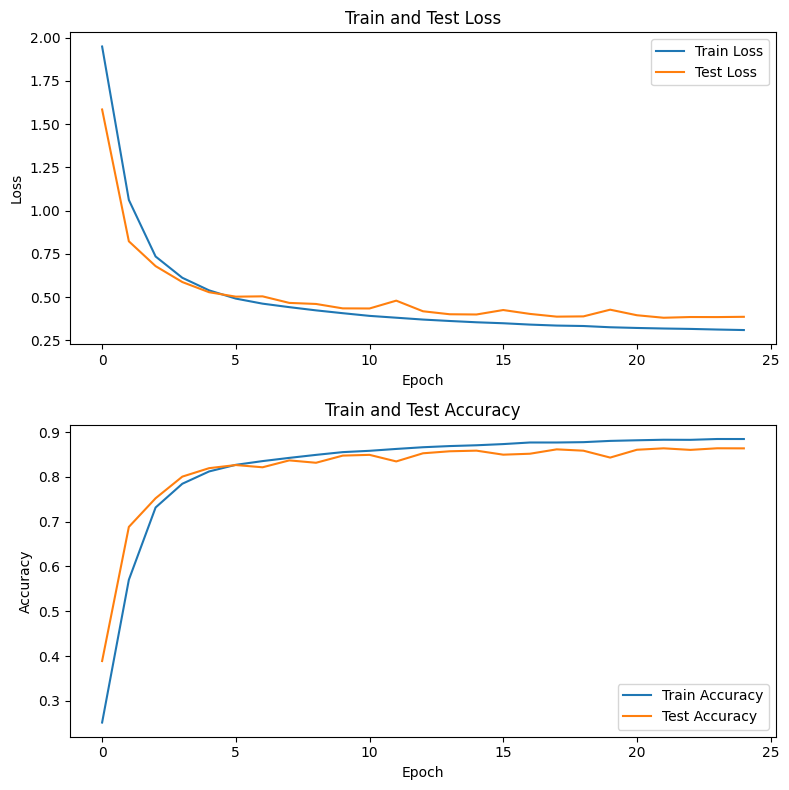

In [22]:
check_log = log[0]

fig, axs = plt.subplots(2, figsize=(8, 8))

axs[0].plot(check_log['train_loss'], label='Train Loss')
axs[0].plot(check_log['test_loss'], label='Test Loss')
axs[0].set_title('Train and Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(check_log['train_accuracy'], label='Train Accuracy')
axs[1].plot(check_log['test_accuracy'], label='Test Accuracy')
axs[1].set_title('Train and Test Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()